# Load Data and Word-Embedding Models

In [1]:
import os
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('train_data.json', 'r'))
val_data = json.load(open('val_data.json', 'r'))
test_data = json.load(open('test_data.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# GRU Implementation

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# Training and Validation Code

In [4]:
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {"B": 0, "I": 1, "O": 2}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"].split()
                labels = data["labels"]
                # Convert text to embeddings
                embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Testing Code

In [5]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {"B": 0, "I": 1, "O": 2}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"].split()
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(token, embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)  
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
        
    if show_labelwise:
        import matplotlib.pyplot as plt
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [6]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [7]:
input_size = 300  # Embedding size
hidden_size = 64  # Hidden size of the RNN
output_size = 3   # BIO encoding: B, I, O

# For Word2Vec Embeddings

In [8]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)

In [9]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2694, Accuracy: 0.9178, F1: 0.6438
Validation: Loss: 0.1750, Accuracy: 0.9382, F1: 0.7444
Epoch 2/10
Training: Loss: 0.1719, Accuracy: 0.9409, F1: 0.7829
Validation: Loss: 0.1568, Accuracy: 0.9463, F1: 0.7793
Epoch 3/10
Training: Loss: 0.1433, Accuracy: 0.9488, F1: 0.8139
Validation: Loss: 0.1520, Accuracy: 0.9485, F1: 0.7907
Epoch 4/10
Training: Loss: 0.1217, Accuracy: 0.9552, F1: 0.8414
Validation: Loss: 0.1521, Accuracy: 0.9497, F1: 0.8025
Epoch 5/10
Training: Loss: 0.1016, Accuracy: 0.9628, F1: 0.8747
Validation: Loss: 0.1567, Accuracy: 0.9495, F1: 0.7977
Epoch 6/10
Training: Loss: 0.0826, Accuracy: 0.9681, F1: 0.8970
Validation: Loss: 0.1668, Accuracy: 0.9471, F1: 0.7902
Epoch 7/10
Training: Loss: 0.0655, Accuracy: 0.9749, F1: 0.9228
Validation: Loss: 0.1721, Accuracy: 0.9495, F1: 0.8024
Epoch 8/10
Training: Loss: 0.0515, Accuracy: 0.9810, F1: 0.9430
Validation: Loss: 0.1818, Accuracy: 0.9492, F1: 0.7997
Epoch 9/10
Training: Loss: 0.0398, Accuracy: 0.9

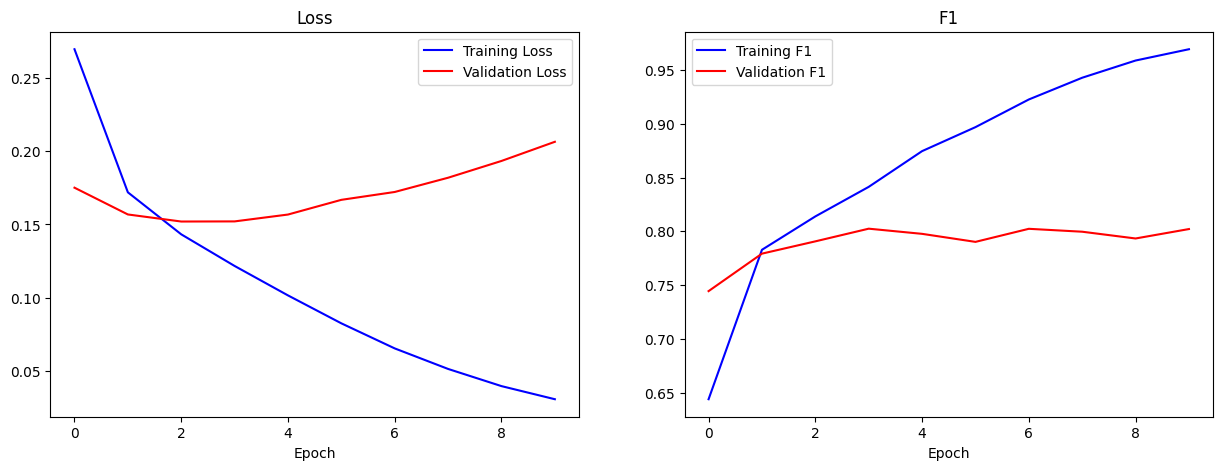

In [10]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [11]:
gru_word2vec_model = gru_word2vec_model.to('cpu')
torch.save(gru_word2vec_model, "t2_model3_word2vec.pt")

In [12]:
test_accuracy, test_f1 = test("t2_model3_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2749576988155668, 1: 0.23118279569892472, 2: 0.32833219671137376}
Labelwise Accuracy Scores:
{0: 0.7019438444924406, 1: 0.5308641975308642, 2: 0.9704367301231803}
GRU with Word2Vec ==> Accuracy: 0.9257, F1: 0.7651


# For GloVe Embeddings

In [13]:
gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)

In [14]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.2931, Accuracy: 0.9124, F1: 0.6021
Validation: Loss: 0.2012, Accuracy: 0.9339, F1: 0.6946
Epoch 2/10
Training: Loss: 0.2082, Accuracy: 0.9326, F1: 0.7299
Validation: Loss: 0.1805, Accuracy: 0.9408, F1: 0.7331
Epoch 3/10
Training: Loss: 0.1712, Accuracy: 0.9425, F1: 0.7795
Validation: Loss: 0.1785, Accuracy: 0.9418, F1: 0.7492
Epoch 4/10
Training: Loss: 0.1455, Accuracy: 0.9512, F1: 0.8207
Validation: Loss: 0.1827, Accuracy: 0.9399, F1: 0.7407
Epoch 5/10
Training: Loss: 0.1240, Accuracy: 0.9591, F1: 0.8540
Validation: Loss: 0.1869, Accuracy: 0.9408, F1: 0.7523
Epoch 6/10
Training: Loss: 0.1067, Accuracy: 0.9641, F1: 0.8756
Validation: Loss: 0.1955, Accuracy: 0.9406, F1: 0.7472
Epoch 7/10
Training: Loss: 0.0926, Accuracy: 0.9697, F1: 0.8968
Validation: Loss: 0.2029, Accuracy: 0.9375, F1: 0.7390
Epoch 8/10
Training: Loss: 0.0804, Accuracy: 0.9742, F1: 0.9115
Validation: Loss: 0.2192, Accuracy: 0.9360, F1: 0.7422
Epoch 9/10
Training: Loss: 0.0712, Accuracy: 0.9

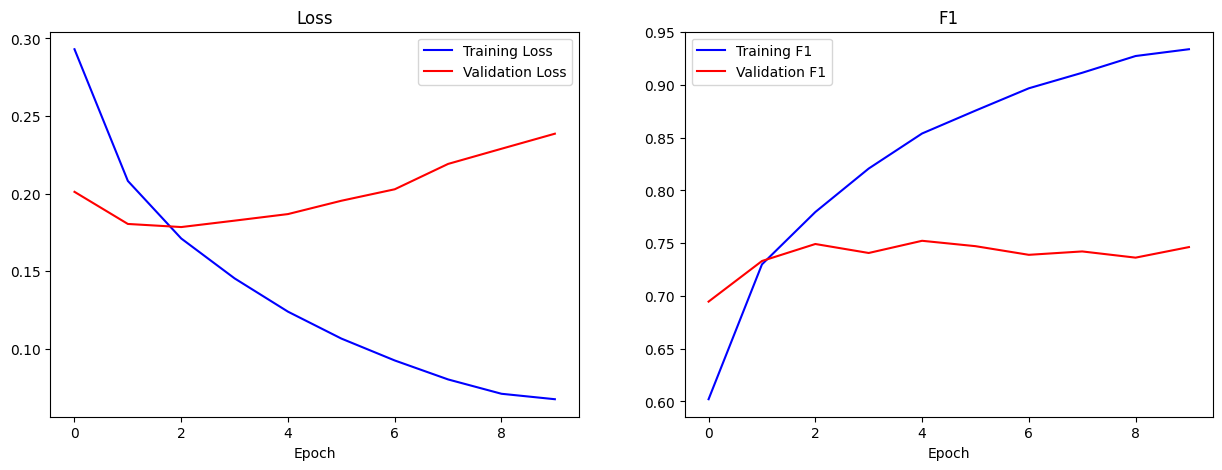

In [15]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [16]:
gru_glove_model = gru_glove_model.to('cpu')
torch.save(gru_glove_model, "t2_model3_glove.pt")

In [17]:
test_accuracy, test_f1 = test("t2_model3_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.24209078404401652, 1: 0.21032863849765257, 2: 0.3290995690632797}
Labelwise Accuracy Scores:
{0: 0.5701943844492441, 1: 0.4609053497942387, 2: 0.97491601343785}
GRU with GloVe ==> Accuracy: 0.9145, F1: 0.7196


# For FastText Embeddings

In [18]:
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)

In [19]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10


Training: Loss: 0.2825, Accuracy: 0.9133, F1: 0.6016
Validation: Loss: 0.1749, Accuracy: 0.9365, F1: 0.7098
Epoch 2/10
Training: Loss: 0.1766, Accuracy: 0.9366, F1: 0.7616
Validation: Loss: 0.1513, Accuracy: 0.9466, F1: 0.7693
Epoch 3/10
Training: Loss: 0.1535, Accuracy: 0.9445, F1: 0.7976
Validation: Loss: 0.1445, Accuracy: 0.9478, F1: 0.7790
Epoch 4/10
Training: Loss: 0.1392, Accuracy: 0.9492, F1: 0.8180
Validation: Loss: 0.1428, Accuracy: 0.9461, F1: 0.7730
Epoch 5/10
Training: Loss: 0.1272, Accuracy: 0.9526, F1: 0.8345
Validation: Loss: 0.1448, Accuracy: 0.9473, F1: 0.7816
Epoch 6/10
Training: Loss: 0.1167, Accuracy: 0.9561, F1: 0.8481
Validation: Loss: 0.1490, Accuracy: 0.9461, F1: 0.7785
Epoch 7/10
Training: Loss: 0.1059, Accuracy: 0.9587, F1: 0.8605
Validation: Loss: 0.1557, Accuracy: 0.9454, F1: 0.7785
Epoch 8/10
Training: Loss: 0.0963, Accuracy: 0.9619, F1: 0.8727
Validation: Loss: 0.1609, Accuracy: 0.9466, F1: 0.7816
Epoch 9/10
Training: Loss: 0.0864, Accuracy: 0.9654, F1: 0.

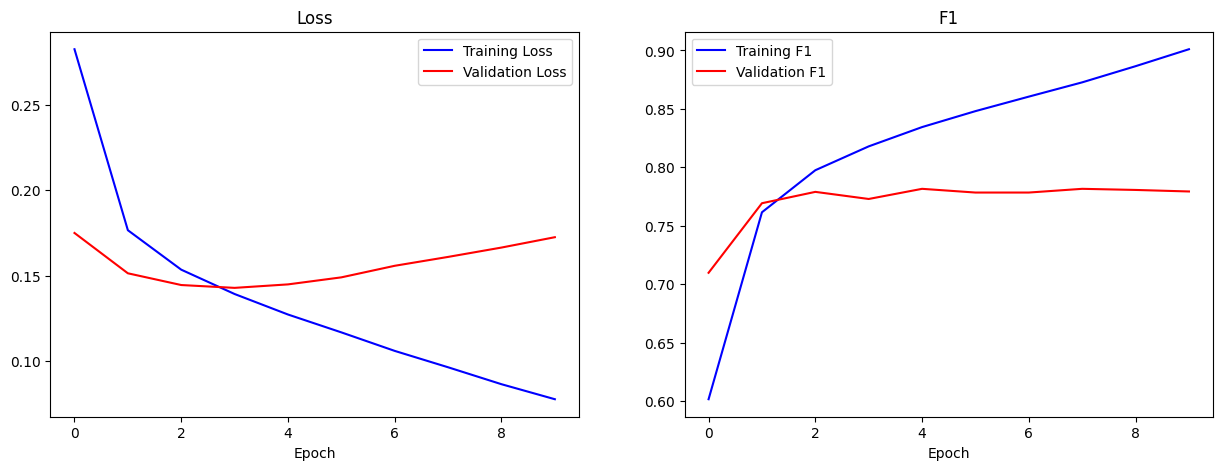

In [20]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [21]:
gru_fasttext_model = gru_fasttext_model.to('cpu')
torch.save(gru_fasttext_model, "t2_model3_fasttext.pt")

In [23]:
test_accuracy, test_f1 = test("t2_model3_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.2729591836734694, 1: 0.22524977293369666, 2: 0.32948195136686304}
Labelwise Accuracy Scores:
{0: 0.693304535637149, 1: 0.5102880658436214, 2: 0.9771556550951848}
GRU with FastText ==> Accuracy: 0.9298, F1: 0.7718
